## Подготовка данных (загрузка данных, общий помощник для графиков)

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_csv('passengers2.csv')

df['Month'] = pd.to_datetime(df['Month'])
df = df.sort_values('Month').set_index('Month')

ref = df['reference']   
tgt = df['target']

# Хелпер для сравнения с эталоном
def plot_pair(series, title):
    plt.figure(figsize=(10, 5))
    plt.plot(ref, label='reference')
    plt.plot(series, label='target (filled)')
    plt.title(title)
    plt.xlabel('Month')
    plt.ylabel('Passengers')
    plt.legend()
    plt.tight_layout()
    plt.show()

df


,reference,target,missing
Month,,,
1949-01-01,112,112.0,NaN
1949-02-01,118,118.0,NaN
1949-03-01,132,132.0,NaN
1949-04-01,129,NaN,129.0
1949-05-01,121,121.0,NaN
...,...,...,...
1960-08-01,606,606.0,NaN
1960-09-01,508,508.0,NaN
1960-10-01,461,461.0,NaN


## Задание 1. Восполнение предыдущими значениями (только «в прошлое», через shift)

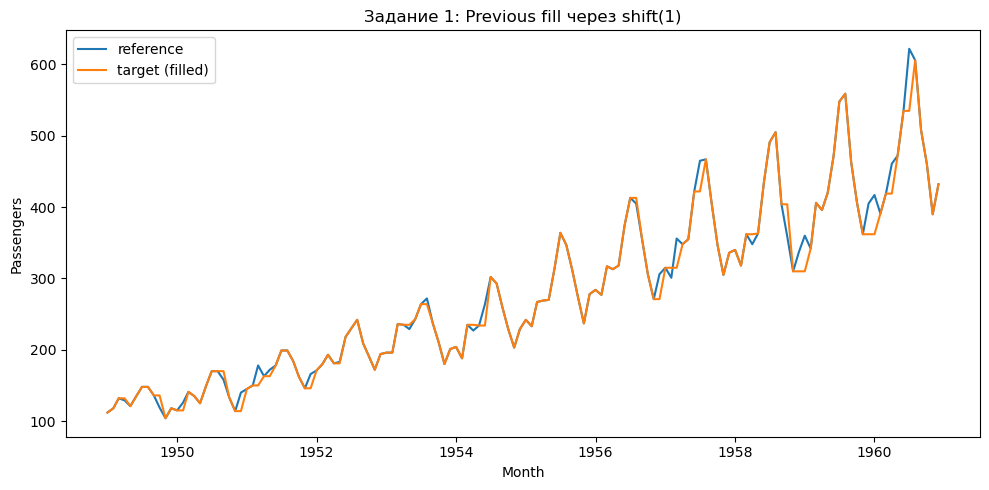

In [6]:
# Идея: пошагово продвигаемся влево→вправо.
# За m итераций заполняется непрерывный блок из m пропусков.
filled_prev_shift = tgt.copy()
for _ in range(len(filled_prev_shift)):
    filled_prev_shift = filled_prev_shift.fillna(filled_prev_shift.shift(1))
# Пропуски в самом начале ряда (если есть) останутся NaN — это корректно.

plot_pair(filled_prev_shift, 'Задание 1: Previous fill через shift(1)')


## Задание 2. Скользящее среднее (window=3) — два способа

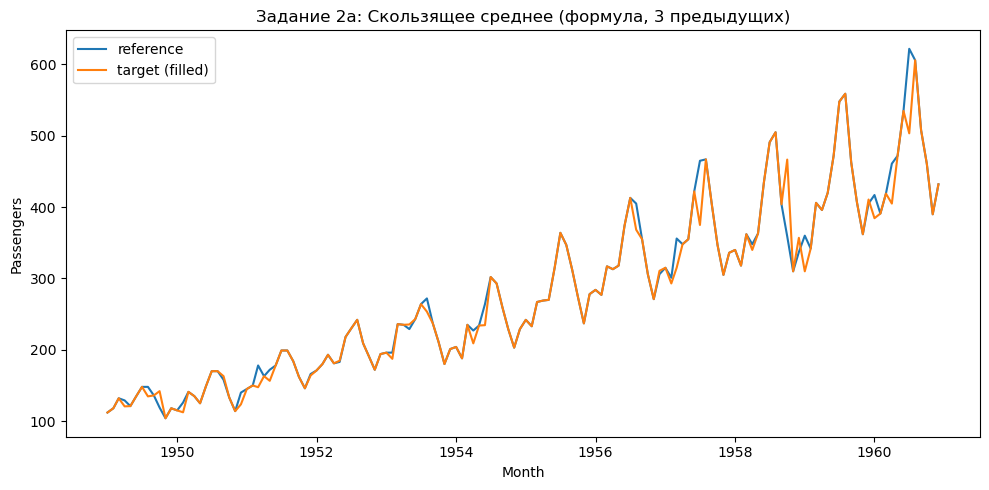

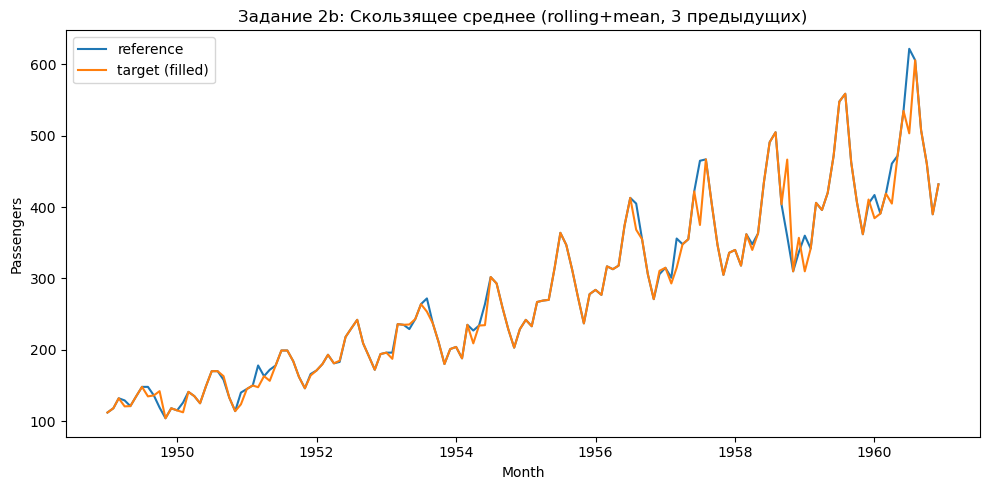

In [7]:
# (2a) Формулой: среднее трёх ПРЕДЫДУЩИХ значений (x_{t-1}, x_{t-2}, x_{t-3})
ma_prev3 = tgt.shift(1).rolling(window=3, min_periods=1).mean()
filled_ma_manual_prev3 = tgt.fillna(ma_prev3)

plot_pair(filled_ma_manual_prev3, 'Задание 2a: Скользящее среднее (формула, 3 предыдущих)')

# (2b) Через pandas rolling+mean (также только «прошлые» за счёт shift(1))
filled_ma_rolling_prev3 = tgt.fillna(tgt.shift(1).rolling(window=3, min_periods=1).mean())

plot_pair(filled_ma_rolling_prev3, 'Задание 2b: Скользящее среднее (rolling+mean, 3 предыдущих)')


## Задание 3. Линейная интерполяция (формула и pandas.interpolate)

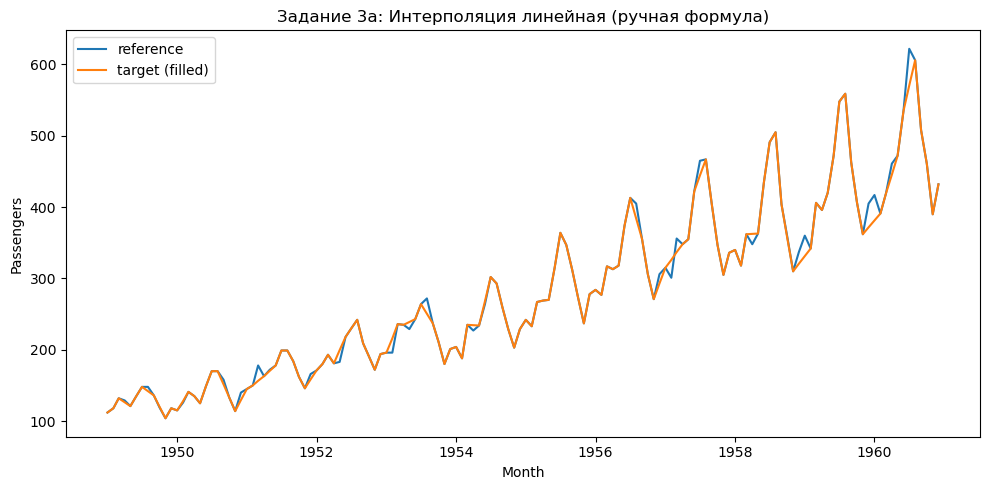

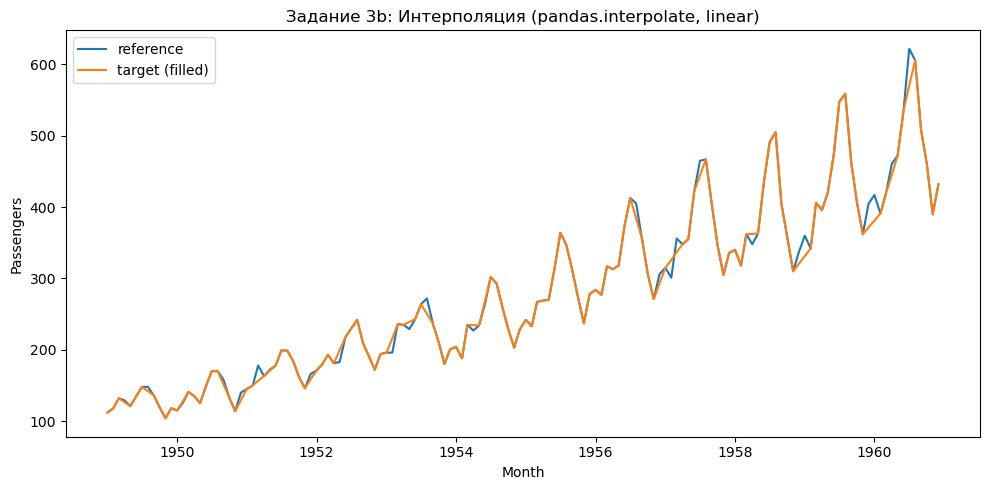

In [8]:
# (3a) Ручной расчёт по формуле:
# y = y0*(x1-x)/(x1-x0) + y1*(x-x0)/(x1-x0), где x — позиция внутри разрыва.
interp_manual = tgt.copy().astype(float)
vals = interp_manual.values
n = len(vals)
i = 0
while i < n:
    if np.isnan(vals[i]):
        start = i - 1
        j = i
        while j < n and np.isnan(vals[j]):
            j += 1
        end = j
        if start >= 0 and end < n and not np.isnan(vals[start]) and not np.isnan(vals[end]):
            x0, x1 = start, end
            y0, y1 = vals[start], vals[end]
            for k in range(start + 1, end):
                x = k
                vals[k] = y0 * (x1 - x) / (x1 - x0) + y1 * (x - x0) / (x1 - x0)
        i = end
    else:
        i += 1
interp_manual = pd.Series(vals, index=interp_manual.index)

plot_pair(interp_manual, 'Задание 3a: Интерполяция линейная (ручная формула)')

# (3b) Стандартная pandas-интерполяция
interp_pd = tgt.interpolate(method='linear')

plot_pair(interp_pd, 'Задание 3b: Интерполяция (pandas.interpolate, linear)')


## Задание 4. Сводная таблица результатов

In [9]:
results = pd.DataFrame({
    'reference': ref,
    'target': tgt,
    'filled_prev_shift': filled_prev_shift,
    'filled_ma_manual_prev3': filled_ma_manual_prev3,
    'filled_ma_rolling_prev3': filled_ma_rolling_prev3,
    'filled_interp_manual': interp_manual,
    'filled_interp_pandas': interp_pd
})
results.head(10)


,reference,target,filled_prev_shift,filled_ma_manual_prev3,filled_ma_rolling_prev3,filled_interp_manual,filled_interp_pandas
Month,,,,,,,
1949-01-01,112,112.0,112.0,112.000000,112.000000,112.0,112.0
1949-02-01,118,118.0,118.0,118.000000,118.000000,118.0,118.0
1949-03-01,132,132.0,132.0,132.000000,132.000000,132.0,132.0
1949-04-01,129,NaN,132.0,120.666667,120.666667,126.5,126.5
1949-05-01,121,121.0,121.0,121.000000,121.000000,121.0,121.0
1949-06-01,135,135.0,135.0,135.000000,135.000000,135.0,135.0
1949-07-01,148,148.0,148.0,148.000000,148.000000,148.0,148.0
1949-08-01,148,NaN,148.0,134.666667,134.666667,142.0,142.0
1949-09-01,136,136.0,136.0,136.000000,136.000000,136.0,136.0


## Задание 5. Простое экспоненциальное сглаживание S_t = d·S_{t-1} + (1-d)·x_t

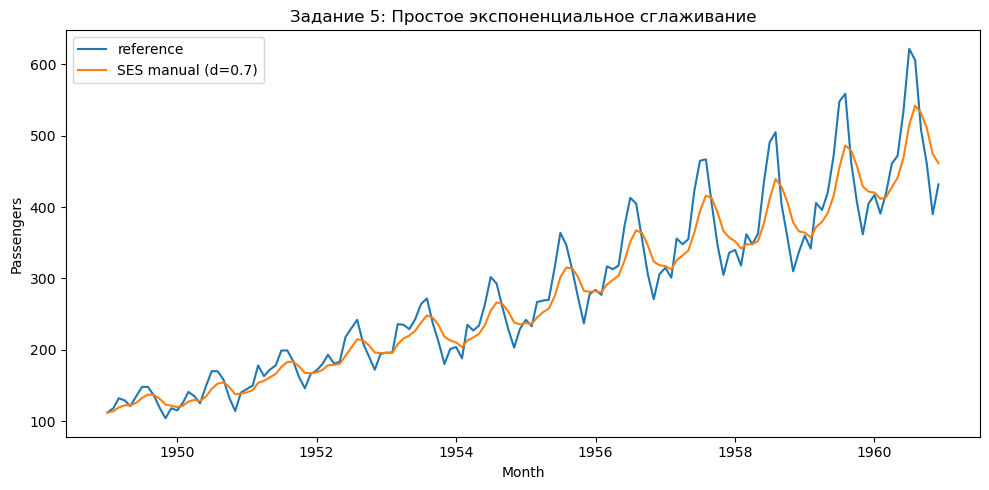

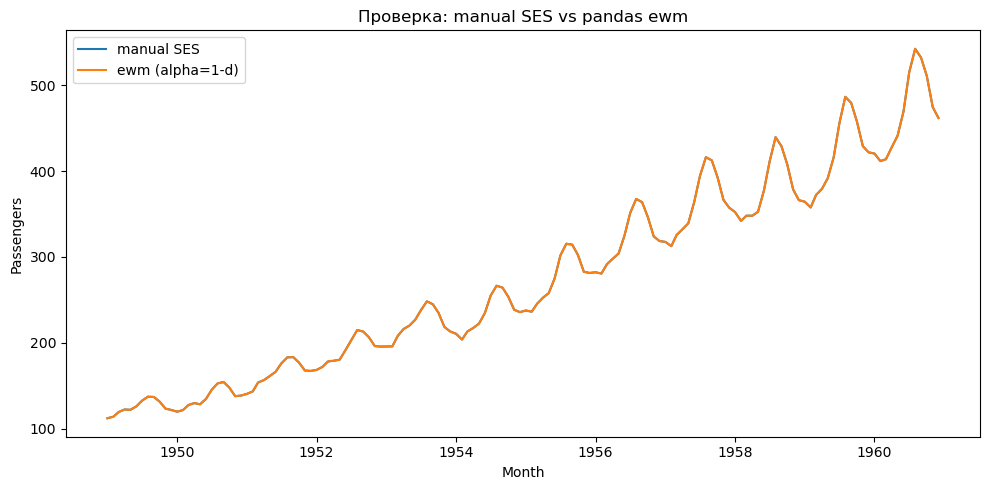

In [10]:
# d ∈ (0,1). Чем БОЛЬШЕ d — тем сильнее влияние прошлого (сильнее сглаживание).
d = 0.7
x = ref.copy()

# Ручная реализация SES
S_manual = pd.Series(index=x.index, dtype=float)
S_manual.iloc[0] = x.iloc[0]
for t in range(1, len(x)):
    S_manual.iloc[t] = d*S_manual.iloc[t-1] + (1-d)*x.iloc[t]

# Эквивалент через pandas ewm: alpha = 1 - d, adjust=False
alpha = 1 - d
S_ewm = x.ewm(alpha=alpha, adjust=False).mean()

# График: сглаженный ряд и исходный
plt.figure(figsize=(10, 5))
plt.plot(x, label='reference')
plt.plot(S_manual, label=f'SES manual (d={d})')
plt.title('Задание 5: Простое экспоненциальное сглаживание')
plt.xlabel('Month'); plt.ylabel('Passengers'); plt.legend(); plt.tight_layout(); plt.show()

# Проверка совпадения manual и ewm
plt.figure(figsize=(10, 5))
plt.plot(S_manual, label='manual SES')
plt.plot(S_ewm, label='ewm (alpha=1-d)')
plt.title('Проверка: manual SES vs pandas ewm')
plt.xlabel('Month'); plt.ylabel('Passengers'); plt.legend(); plt.tight_layout(); plt.show()
